## Solution to the second project

#### All the imports here

In [24]:
import numpy as np
import numpy.linalg as la
import random
import sys
import math
import time

#### Making matplotlib more tolerable

In [25]:
import matplotlib.pyplot as plt
%pylab inline
plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Task 3.1 (Marek)

In [26]:
def calcDistance(center, point):
    return np.sqrt(np.power(center[0] - point[0], 2) + np.power(center[1] - point[1], 2))
    #return math.sqrt((center[0] - point[0])**2 + (center[1] - point[1])**2)


def assignPointsToNearestCluster(centers, data):
    index = np.zeros(len(data[0, :]))
    # assign points to clusters/centers
    for i in range(len(data[0, :])):
        min_dist = sys.float_info.max
    cluster = 0
    for j in range(len(centers[:, 0])):
        distFromCenterToPoint = calcDistance(centers[j, :], data[:, i])
        if distFromCenterToPoint < min_dist:
            min_dist = distFromCenterToPoint
            cluster = j
    
    index[i] = cluster
    return index


def calculateObjectiveFunction(centers, data, index):
    error = 0.0
    for i in range(len(data[0, :])):
        for j in range(len(centers[:, 0])):
            if index[i] == j:
                error += calcDistance( centers[j, :], data[:, i])
    
    return error


def calcMeanOfCenter(centers, index, i ):
    centers[i, 0] = 0.0
    centers[i, 1] = 0.0
    
    # calculate new position of centroid i
    no_of_points_in_cluster = sum((index) == i)  # sum number of points assigned to a center	
    
    for j in range(len(index)):  # loop over all indexes of points
        if index[j] == i:  # if point is assigned to center add it
            centers[i, 0] = centers[i, 0] + data[0, i]
            centers[i, 1] = centers[i, 1] + data[1, i]
    
    if no_of_points_in_cluster != 0:
        centers[i, 0] = centers[i, 0] / float(no_of_points_in_cluster)
        centers[i, 1] = centers[i, 1] / float(no_of_points_in_cluster)
    
    return centers


def determineWinnerCentroid(centers, x):
    min_dist = sys.float_info.max
    center_index = 0
    for i in range(len(centers[:, 0])):
        distFromCenterToPoint = calcDistance(centers[i, :], x)
        if (distFromCenterToPoint < min_dist):
            min_dist = distFromCenterToPoint
            center_index = i
    
    return center_index


def LIoyds(data, k):
    min_val_X = min(data[0, :])
    min_val_Y = min(data[1, :])
    max_val_X = max(data[0, :])
    max_val_Y = max(data[1, :])
    
    # initialize centers
    centers = np.zeros((k, 2), np.float64 )
    for i in range(k):
        centers[i, 0] = random.uniform(min_val_X, max_val_X)
        centers[i, 1] = random.uniform(min_val_Y, max_val_Y)
    
    index = np.zeros(len(data[0, :]))
    index_previous = np.zeros(len(data[0, :]))
    
    change = True
    # loop until there is no change in assignment to clusters
    while change == True:
        index = assignPointsToNearestCluster(centers, data)
    
        # if assignment to centers did not change then stop algorithm
        if np.array_equal( index , index_previous ):
            change == False
            break
    
        #compute centers for all centroids
        for l in range(k):
            centers = calcMeanOfCenter(centers, index, l)
    
        index_previous = np.copy( index )
    
    return index, centers


def Hartigan(data, k):
    min_val_X = min(data[0,:])
    min_val_Y = min(data[1,:])
    max_val_X = max(data[0,:])
    max_val_Y = max(data[1,:])
    
    # initialize centers
    centers = np.zeros((k, 2), np.float64 )
    
    #randomly assign points to clusters
    index = np.zeros( len(data[0,:]) )
    for i in range( len(data[0,:]) ):
        index[i] = random.randint(0,k-1)
    
    #compute mean of centers
    centers = calcMeanOfCenter(centers, index, 0)
    centers = calcMeanOfCenter(centers, index, 1)
    centers = calcMeanOfCenter(centers, index, 2)
    
    change = True
    # loop until there is no change in assignment to clusters
    while change == True:
    
        change = False
        for j in range( len(data[0,:]) ):
            init_center = index[j] #get center i for point j
            index[j]= -1 # remove point j from center
            centers = calcMeanOfCenter(centers, index, init_center) #recalculate mean for center i
            
            min_error = sys.float_info.max
            proper_cluster = 0
            for i in range(k):
                index[j] = i #assign point j to cluster i
                objFunResult = calculateObjectiveFunction(centers, data, index)
                if ( min_error > objFunResult ):
                    min_error = objFunResult
                    proper_cluster = i
    
            if ( proper_cluster != init_center ): # if change in assignment to centers was found
                change = True # continue iterations
    
            index[j] = proper_cluster #assign point to cluster for which objective function is the lowest
    
            centers = calcMeanOfCenter(centers, index, proper_cluster) #recalculate mean for center i
        
    return index, centers



def MacQueen(data , k):
    min_val_X = min(data[0,:])
    min_val_Y = min(data[1,:])
    max_val_X = max(data[0,:])
    max_val_Y = max(data[1,:])
    
    # initialize centers
    centers = np.zeros((k, 2), np.float64 )
    for i in range(k):
        centers[i,0] = random.uniform( min_val_X , max_val_X )
        centers[i,1] = random.uniform( min_val_Y , max_val_Y )
    
    n = 0
    for j in range( len(data[0,:]) ):
        center_index = determineWinnerCentroid(centers , data[:,j])
        n += 1
        centers[center_index,:] += 1/float(n)*( data[:,j] - centers[center_index,:])  
    
    index = assignPointsToNearestCluster(centers , data)
    
    return index, centers


def plotData( data , indexes , centers , str, axs):

    bool_idx = (indexes == 0)
    axs.scatter(data[0,bool_idx], data[1,bool_idx], color='red')
    axs.scatter(centers[0,0], centers[0,1], s=100 , color='red', edgecolors='black')

    bool_idx = (indexes == 1)
    axs.scatter(data[0,bool_idx], data[1,bool_idx], color='orange')
    axs.scatter(centers[1,0], centers[1,1], s=100 , color='orange', edgecolors='black')

    bool_idx = (indexes == 2)
    axs.scatter(data[0,bool_idx], data[1,bool_idx], color='green')
    axs.scatter(centers[2,0], centers[2,1], s=100 , color='green', edgecolors='black')

    axs.set_title(str)
    return axs


def measureAlgRunTimes(data):
    start = time.time()
    for i in range(10):
        [indexes, centers] = LIoyds(data , 3)
    end = time.time()
    avg_time = (end - start)/10.0

    print "LIoyds algorithm average time:   ",avg_time

    start = time.time()
    for i in range(10):
        [indexes, centers] = Hartigan(data , 3)
    end = time.time()
    avg_time = (end - start)/10.0

    print "Hartigan algorithm average time:   ",avg_time

    start = time.time()
    for i in range(10):
        [indexes, centers] = MacQueen(data , 3)
    end = time.time()
    avg_time = (end - start)/10.0

    print "MacQueen algorithm average time:   ",avg_time

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will r

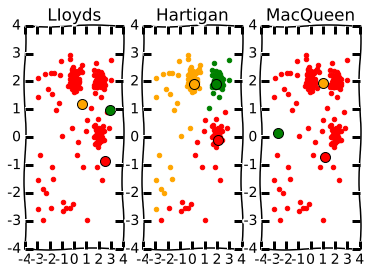

LIoyds algorithm average time:    0.000692892074585
Hartigan algorithm average time:    3.88828620911
MacQueen algorithm average time:    0.00585827827454


In [27]:
data = np.loadtxt('resources/data-clustering-1.csv', None, comments='#', delimiter=',')

fig = plt.figure()
axs1 = fig.add_subplot(131)
axs2 = fig.add_subplot(132)
axs3 = fig.add_subplot(133)

[indexes, centers] = LIoyds(data , 3)
axs1 = plotData(data,indexes,centers, "LIoyds" , axs1)

[indexes, centers] = Hartigan(data , 3)
axs2 = plotData(data,indexes,centers, "Hartigan", axs2)

[indexes, centers] = MacQueen(data , 3)
axs3 = plotData(data,indexes,centers, "MacQueen", axs3)

plt.show()

measureAlgRunTimes(data)

### Task 3.3 (Yakun)

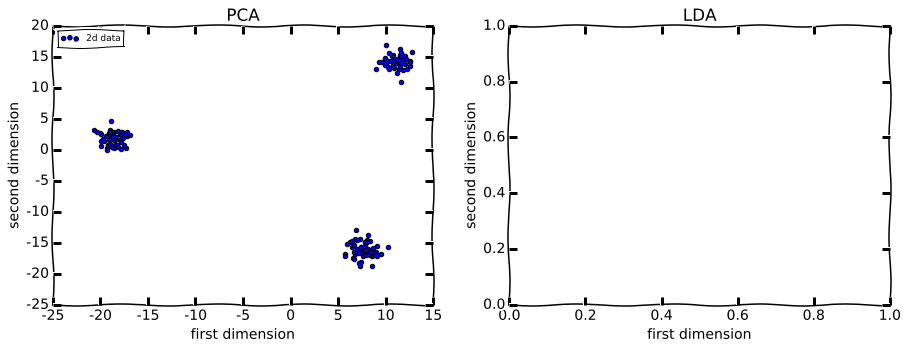

In [40]:
dataX = np.loadtxt('resources/data-dimred-X.csv', None, comments='#', delimiter=',')
dataY = np.loadtxt('resources/data-dimred-y.csv', None, comments='#', delimiter=',')
num_row, num_col = np.shape(dataX)

# add all columns and divide the number of columns
x_mean = dataX.sum(axis=1, dtype='float') / num_col 

# substract all columns by x_mean to move data set to 0 mean, get X tranpose here
Xtr = np.transpose(dataX) - x_mean

# data covariance matrix
X = np.transpose(Xtr)
C = np.dot(X, Xtr) / num_col

# compute eigen values and eigen vectors
evalsh, evectsh = la.eigh(C)

# sort eigen values and eigen vectors in descending order
indx = np.argsort(evalsh)[::-1]
evalsh = evalsh[indx]
evectsh = evectsh[:, indx]

# use largest two eigen vector to project the data into 2d
X2d = np.dot(np.transpose(evectsh[:, [0, 1]]), X)

# plot
fig,axes = subplots(ncols=2, figsize=(15,5))
ax = axes[0]
ax2 = axes[1]
ax.set_title('PCA')
ax.set_xlabel('first dimension')
ax.set_ylabel('second dimension')
ax.scatter(X2d[0], X2d[1], label='2d data')
legend = ax.legend(loc='upper left', prop={'size':9})

ax2.set_title('LDA')
ax2.set_xlabel('first dimension')
ax2.set_ylabel('second dimension')